In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import utils
import imageio

2023-05-15 15:34:45.416889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 15:34:45.628803: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 15:34:45.673417: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-15 15:34:46.424912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
dat = np.load('imgs_size/RMTS_size_m0.npz')

X_train = dat['train_x']
y_train = dat['train_y']
X_test = dat['test_x']
y_test = dat['test_y']
X_train = (255 - X_train) / 255
X_test = (255 - X_test) / 255

X_full = np.expand_dims(X_train, axis=-1)
y_full = y_train
X_train = X_full
X_test = np.expand_dims(X_test, axis=-1)
print(X_full.shape, y_full.shape, X_test.shape, y_test.shape)

dat = np.load('imgs_size/RMTS_size_pretrain.npz')
X_pair = dat['x']
y_pair = dat['y']
X_pair = 255 - X_pair
X_pair = np.expand_dims(X_pair, axis=-1)
print(X_pair.shape, y_pair.shape)

(8910, 6, 32, 32, 1) (8910,) (990, 6, 32, 32, 1) (990,)
(200, 2, 32, 32, 1) (200,)


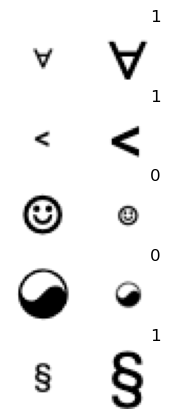

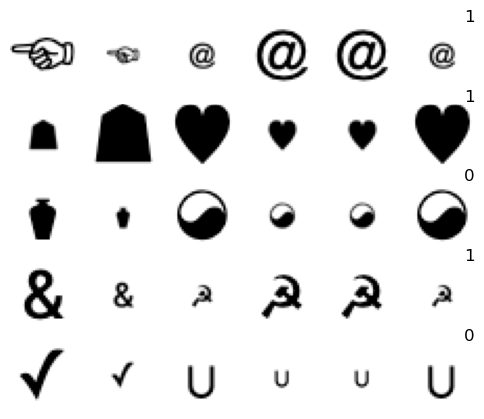

In [3]:
def display_sample(X, y, to_show=10):
    seq_len = int(X.shape[1]/2)
    fig, axarr = plt.subplots(to_show, 2*seq_len, figsize=(2*seq_len, 5))
    plt.rcParams['axes.titlepad'] = -14  
    for i in range(to_show):
        ind = np.random.choice(range(len(X)), 1)[0]
        for j in range(2*seq_len):
            axarr[i,j].imshow(X[ind,j], cmap='gray_r')
            axarr[i,j].axis('off')
            if (j == 2*seq_len-1):
                axarr[i,j].set_title('%d' % y[ind], loc='right')
    plt.show()


display_sample(X_pair, y_pair, to_show=5)
display_sample(X_train, y_train, to_show=5)


## Abstractor

In [4]:
from simplest_abstractor import CnnEncoder
from abstracters import SimpleAbstractor, RelationalAbstracter
from abstractor import Abstractor
from tensorflow.keras import layers

In [10]:
embedding_dim = 64

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=1,
        symbol_dim=10,
        proj_dim=64,
        symmetric_rels=False,
        encoder_kwargs=None,
        rel_activation_type='softmax',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=True, name='cnn_encoder')

class AbstractorRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        # self.abstractor = SimpleAbstractor(**abstractor_kwargs)
        self.abstractor = Abstractor(**abstractor_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.abstractor(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

abstractor_model = AbstractorRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model(X_train[:32])
abstractor_model.summary()

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 abstractor_2 (Abstractor)   multiple                  8490      
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  1952      
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 115,179
Trainable params: 10,475
Non-trainable params: 104,704
_________________________________________________________________


In [11]:
history = abstractor_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=10, verbose=1, batch_size=32)

Epoch 1/10
279/279 [==============================] - 16s 53ms/step - loss: 0.6970 - binary_accuracy: 0.5010 - val_loss: 0.6931 - val_binary_accuracy: 0.5071
Epoch 2/10
279/279 [==============================] - 14s 50ms/step - loss: 0.5189 - binary_accuracy: 0.6820 - val_loss: 0.0753 - val_binary_accuracy: 0.9992
Epoch 3/10
279/279 [==============================] - 14s 50ms/step - loss: 0.0348 - binary_accuracy: 0.9975 - val_loss: 0.0112 - val_binary_accuracy: 1.0000
Epoch 4/10
279/279 [==============================] - 14s 51ms/step - loss: 0.0111 - binary_accuracy: 0.9992 - val_loss: 0.0048 - val_binary_accuracy: 1.0000
Epoch 5/10
279/279 [==============================] - 14s 51ms/step - loss: 0.0047 - binary_accuracy: 0.9999 - val_loss: 0.0024 - val_binary_accuracy: 1.0000
Epoch 6/10
279/279 [==============================] - 14s 51ms/step - loss: 0.0030 - binary_accuracy: 0.9999 - val_loss: 0.0014 - val_binary_accuracy: 1.0000
Epoch 7/10
279/279 [==============================] 

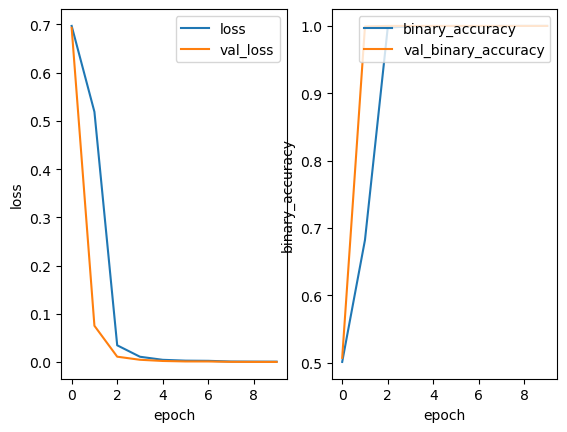

In [12]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [13]:
out = abstractor_model(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [14]:
out = abstractor_model(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 100.00%



## CorelNet

In [19]:
from simplest_abstractor import CnnEncoder
from multi_head_relation import MultiHeadRelation
from tensorflow.keras import layers

In [78]:
embedding_dim = 64

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=1,
        symbol_dim=10,
        proj_dim=64,
        symmetric_rels=False,
        encoder_kwargs=None,
        rel_activation_type='softmax',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=True, name='cnn_encoder')

class CorelNetRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = tf.matmul(x, x, transpose_b=True)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

corelnet_model = CorelNetRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32])
corelnet_model.summary()

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 flatten_30 (Flatten)        multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  1184      
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 105,921
Trainable params: 1,217
Non-trainable params: 104,704
_________________________________________________________________


In [50]:
x = layers.TimeDistributed(corelnet_model.cnn_encoder)(X_train[1000:1008])
x.shape

TensorShape([8, 6, 64])

In [89]:
x = tf.map_fn(abstractor_model.cnn_encoder, X_train[1000:1008].astype('float32'))
x.shape

TensorShape([8, 6, 64])

In [90]:
np.dot(x[0, 0, :], x[0, 5, :])

25348.71

In [91]:
tf.matmul(x, x, transpose_b=True)

<tf.Tensor: shape=(8, 6, 6), dtype=float32, numpy=
array([[[25360.164, 25341.52 , 25348.709, 25381.666, 25381.666,
         25348.709],
        [25341.52 , 25322.963, 25330.127, 25363.   , 25363.   ,
         25330.127],
        [25348.709, 25330.127, 25337.307, 25370.195, 25370.195,
         25337.307],
        [25381.666, 25363.   , 25370.195, 25403.27 , 25403.27 ,
         25370.195],
        [25381.666, 25363.   , 25370.195, 25403.27 , 25403.27 ,
         25370.195],
        [25348.709, 25330.127, 25337.307, 25370.195, 25370.195,
         25337.307]],

       [[25310.43 , 25327.36 , 25347.115, 25321.506, 25321.506,
         25347.115],
        [25327.36 , 25344.404, 25364.098, 25338.445, 25338.445,
         25364.098],
        [25347.115, 25364.098, 25384.078, 25358.197, 25358.197,
         25384.078],
        [25321.506, 25338.445, 25358.197, 25332.637, 25332.637,
         25358.197],
        [25321.506, 25338.445, 25358.197, 25332.637, 25332.637,
         25358.197],
        [253

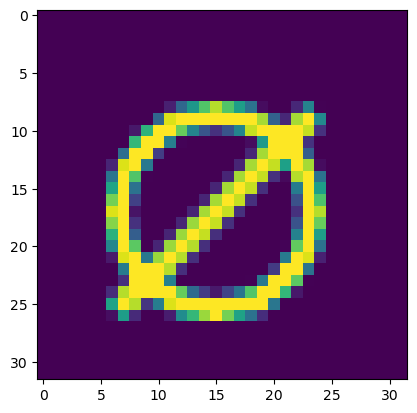

In [65]:
plt.imshow(X_train[1000:1008][0, 4, :])

In [88]:
np.max(np.abs(x[0, -3, :] - x[0, 0, :]))

0.1340599

In [47]:
history = corelnet_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=10, verbose=1, batch_size=32)

Epoch 1/10
279/279 [==============================] - 15s 49ms/step - loss: 2.1491 - binary_accuracy: 0.4949 - val_loss: 0.8594 - val_binary_accuracy: 0.5071
Epoch 2/10
279/279 [==============================] - 13s 47ms/step - loss: 0.7337 - binary_accuracy: 0.5006 - val_loss: 0.6948 - val_binary_accuracy: 0.5071
Epoch 3/10
279/279 [==============================] - 13s 48ms/step - loss: 0.7364 - binary_accuracy: 0.4974 - val_loss: 0.7358 - val_binary_accuracy: 0.4929
Epoch 4/10
279/279 [==============================] - 13s 47ms/step - loss: 0.7495 - binary_accuracy: 0.5075 - val_loss: 0.6942 - val_binary_accuracy: 0.4929
Epoch 5/10
279/279 [==============================] - 13s 47ms/step - loss: 0.7469 - binary_accuracy: 0.5037 - val_loss: 0.7157 - val_binary_accuracy: 0.4929
Epoch 6/10
279/279 [==============================] - 13s 47ms/step - loss: 0.7375 - binary_accuracy: 0.4990 - val_loss: 0.8578 - val_binary_accuracy: 0.4929
Epoch 7/10
279/279 [==============================] 

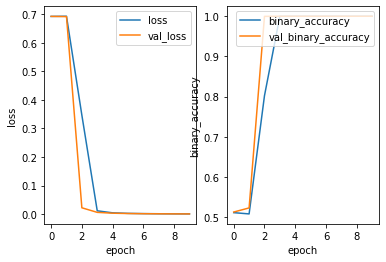

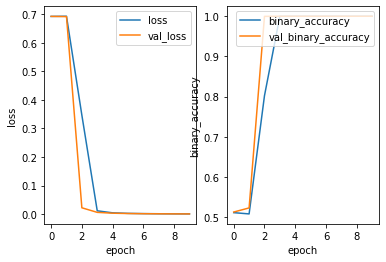

In [ ]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [ ]:
out = cnn_abstractor(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [ ]:
out = cnn_abstractor(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 100.00%



## Transformer

In [16]:
from simplest_abstractor import CnnEncoder
# from abstracters import SimpleAbstractor, RelationalAbstracter
# from abstractor import Abstractor
from transformer_modules import Encoder
from tensorflow.keras import layers

In [17]:
embedding_dim = 128

encoder_kwargs = dict(
    num_layers=1, 
    num_heads=1, 
    dff=128,
    dropout_rate=0.1)

cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=True, name='cnn_encoder')

class TransformerRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, encoder_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        self.encoder = Encoder(**encoder_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

transformer_model = TransformerRMTSModel(embedding_dim, encoder_kwargs, name='rmts_transformer')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
transformer_model(X_train[:32])
transformer_model.summary()

Model: "rmts_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  205120    
                                                                 
 encoder (Encoder)           multiple                  99584     
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  24608     
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 329,345
Trainable params: 124,225
Non-trainable params: 205,120
_________________________________________________________________


In [18]:
history = transformer_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=100, verbose=1, batch_size=32)

Epoch 1/100
279/279 [==============================] - 18s 56ms/step - loss: 0.7135 - binary_accuracy: 0.5044 - val_loss: 0.6943 - val_binary_accuracy: 0.4929
Epoch 2/100
279/279 [==============================] - 15s 53ms/step - loss: 0.6994 - binary_accuracy: 0.5028 - val_loss: 0.6960 - val_binary_accuracy: 0.5071
Epoch 3/100
279/279 [==============================] - 15s 53ms/step - loss: 0.6990 - binary_accuracy: 0.4990 - val_loss: 0.7054 - val_binary_accuracy: 0.4929
Epoch 4/100
279/279 [==============================] - 15s 54ms/step - loss: 0.6978 - binary_accuracy: 0.4980 - val_loss: 0.6945 - val_binary_accuracy: 0.4929
Epoch 5/100
279/279 [==============================] - 15s 54ms/step - loss: 0.6971 - binary_accuracy: 0.5010 - val_loss: 0.6932 - val_binary_accuracy: 0.4929
Epoch 6/100
279/279 [==============================] - 15s 54ms/step - loss: 0.6951 - binary_accuracy: 0.5025 - val_loss: 0.6935 - val_binary_accuracy: 0.5071
Epoch 7/100
279/279 [=========================

KeyboardInterrupt: 

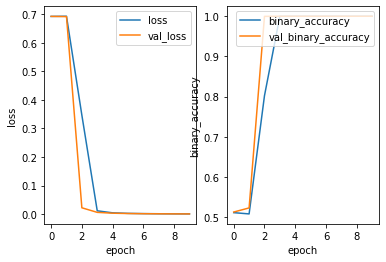

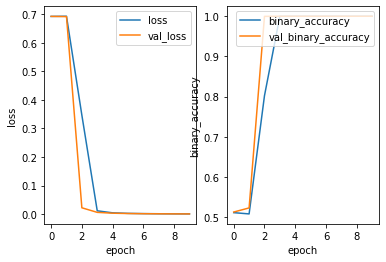

In [ ]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [ ]:
out = cnn_abstractor(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [ ]:
out = cnn_abstractor(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 100.00%



## Learning curve evaluation

In [29]:
def create_callbacks(patience=7):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=0, start_from_epoch=30, mode='auto', restore_best_weights=True, verbose=True))
    return callbacks

def train_abstractor_models(train_sizes, num_trials, num_epochs, relation=None):
    from tqdm import tqdm
    from sklearn.model_selection import train_test_split
    accs = list()
    n_val = 100
    for n in tqdm(train_sizes):
        trial_accs = []
        for trial in np.arange(num_trials):
            model = initialize_pretrained_abstractor(pretrained_relation=relation)
            X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, train_size=n, test_size=n_val)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=create_callbacks(), epochs=num_epochs, verbose=0)
            out = model(X_test)
            yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
            acc = 100*np.mean(yhat==y_test)
            trial_accs.append(acc)
        accs.append(trial_accs)
    return accs

In [ ]:
num_epochs = 200
num_trials = 10

pretrained_n = [5, 10, 50, 100, 150, 200, 250, 300]
pretrained_accs = train_abstractor_models(pretrained_n, num_trials=num_trials, num_epochs=num_epochs,   relation=pretrained_relation)


In [ ]:
num_epochs = 200
num_trials = 50
de_novo_n = [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
de_novo_accs = train_abstractor_models(de_novo_n, num_trials=num_trials, num_epochs=num_epochs, relation=None)



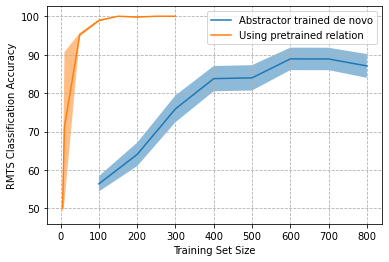

In [156]:
def plot_comparison(pretrained_n, pretrained_accs, scratch_n, scratch_accs):
    import scipy.stats
    scratch_accuracy = np.mean(scratch_accs, axis=1)
    scratch_acc_sem = scipy.stats.sem(scratch_accs, axis=1)
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(scratch_n, scratch_accuracy, label='Abstractor trained de novo')
    ax.fill_between(scratch_n, scratch_accuracy - scratch_acc_sem,
        scratch_accuracy + scratch_acc_sem, alpha=0.5)
    ax.plot(pretrained_n, pretrained_accuracy, label='Using pretrained relation')
    ax.fill_between(pretrained_n, pretrained_accuracy - pretrained_acc_sem,
        pretrained_accuracy + pretrained_acc_sem, alpha=0.5)
    ax.set_xlabel('Training Set Size')
    ax.legend()
    ax.set_ylabel('RMTS Classification Accuracy')
    ax.grid(linestyle='dashed')
    fig.savefig('rmts_accuracies.pdf')
    plt.show()

plot_comparison(pretrained_n, pretrained_accs, de_novo_n, de_novo_accs)